In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pltio
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from datetime import datetime    

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def data_analysis_procedure(data_df):
    print("Starting data analysis...")
    #print(daily_augmented.head())
    
    # Calc rolling mean with window m
    m=15
    qty_roll_median = data_df.qty.rolling(window=m).median()
    median_first_m = np.median(data_df.iloc[:15, 0])
    full_roll_median = qty_roll_median.fillna(median_first_m)

    # Add signals for rolling mean and compatibility of phenomena
    new_signal_vals = [1 if val > full_roll_median[idx] else -1 for idx, val in enumerate(data_df.qty.values)]
    data_df["rolling_medianlbl"] = new_signal_vals

    # Calc annual means
    data_df["yearly_median"] = np.zeros(data_df.shape[0])
    yearly_range = range(min(data_df.index.year), max(data_df.index.year)+1)
    for i in yearly_range:
        median = data_df.loc[str(i)].qty.median()
        data_df.loc[str(i), "yearly_median"] = median

    # Add a singal of months and calculate monthly means
    data_df["month"] = data_df.index.month
    monthly_medians = data_df.qty.resample("M").median()    
    data_df["monthly_median"] = [monthly_medians.loc[str(daily_idx.year)+"-"+str(daily_idx.month)].values[0] for daily_idx in data_df.index]

    # Yearly mean lbl
    data_df["ymedian_lbl"] = [1 if val > data_df["yearly_median"][idx] else -1 for idx, val in enumerate(data_df.qty.values)]

    print("Added rolling, yearly and monthly median signals, needed for statistical analysis.")
    print("Beginning plots and tests.\n")
    #print(data_df.head())
    
    # Day of the week analysis
    plt.figure(figsize=(14,8))
    plt.title("Sales through time in different days of the week")
    ax = sns.scatterplot(x=range(0, len(data_df)), y="qty", hue="day_of_week", palette="Set3",\
                         size="day_of_week", sizes=(60, 180), legend="full", data=data_df)
    ax.set(xlabel="Time steps")
    plt.show()
    
    dow_ctg_matrix = pd.crosstab(data_df["rolling_medianlbl"], data_df["day_of_week"])
    print(dow_ctg_matrix, "\n")
    print("Running Chi-Square test...")
    print(chi2_contingency(dow_ctg_matrix))
    
    # Month of the year analysis (holiday seasons)
    plt.figure(figsize=(14,8))
    plt.plot(data_df.qty, label="Sales data")
    plt.plot(qty_roll_median, label="Rolling median with window "+str(m)) 
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(16,8))
    plt.title("Sales through time in different months ")
    plt.plot(range(0, len(data_df)), data_df.yearly_median.values, label="yearly median")
    ax = sns.scatterplot(x=range(0, len(data_df)), y="qty", hue="month", palette="tab20", size="month", sizes=(60, 100),\
                         legend="full", data=data_df)
    ax.set(xlabel="Time steps")
    plt.show()
    
    # Build a contingency table for the sales by months and the annual mean
    moy_ctg_matrix = pd.crosstab(data_df["ymedian_lbl"], data_df["month"])
    print(moy_ctg_matrix, "\n")
    print("Running Chi-Square test...")
    print(chi2_contingency(moy_ctg_matrix))
    
    # Rainy or non rainy weather analysis
    weather_totals = data_df.groupby(pd.Grouper("conditions")).agg({
        "qty": np.mean
    })
    weather_totals["counts"] = data_df.conditions.value_counts()
    weather_totals.columns = ["mean_qty", "counts"]
    weather_totals.sort_values(by="mean_qty", ascending=False, inplace=True)
    print("\nMean sales when the weather is rainy (-1) and when it is not (1) for the whole year:")
    print(weather_totals)
    
    no_sales_data_df = data_df.copy(deep=True)
    no_sales_data_df = no_sales_data_df.drop(no_sales_data_df[no_sales_data_df.index.month.isin([1, 2, 7, 8, 12])].index, axis=0)    
    weather_totals_nosales = no_sales_data_df.groupby(pd.Grouper("conditions")).agg({
        "qty": np.mean
    })
    weather_totals_nosales["counts"] = no_sales_data_df.conditions.value_counts()
    weather_totals_nosales.columns = ["mean_qty", "counts"]
    weather_totals_nosales.sort_values(by="mean_qty", ascending=False, inplace=True)
    print("\nMean sales when the weather is rainy (-1) and when it is not (1) without sale seasons:")
    print(weather_totals_nosales)
    print()

In [3]:
# Sales data for all shopping centers
milan_cc_arese_data = pd.read_csv("../datasets/ts_data/newdaily/daily_aug/aug_milan_cc_arese_data.csv", index_col=[0], parse_dates=True)
turin_cc_beina_data = pd.read_csv("../datasets/ts_data/newdaily/daily_aug/aug_turin_cc_beina_data.csv", index_col=[0], parse_dates=True)
turin_cc_juve_data = pd.read_csv("../datasets/ts_data/newdaily/daily_aug/aug_turin_cc_juve_data.csv", index_col=[0], parse_dates=True)
turin_cc_niche_data = pd.read_csv("../datasets/ts_data/newdaily/daily_aug/aug_turin_cc_niche_data.csv", index_col=[0], parse_dates=True)
turin_cc_torin_data = pd.read_csv("../datasets/ts_data/newdaily/daily_aug/aug_turin_cc_torin_data.csv", index_col=[0], parse_dates=True)
rome_cc_eur2_data = pd.read_csv("../datasets/ts_data/newdaily/daily_aug/aug_rome_cc_eur2_data.csv", index_col=[0], parse_dates=True)
shop_list = [milan_cc_arese_data, turin_cc_beina_data, turin_cc_juve_data, \
            turin_cc_niche_data, turin_cc_torin_data, rome_cc_eur2_data]

In [4]:
all_cc = pd.concat(
    [milan_cc_arese_data, turin_cc_beina_data, turin_cc_juve_data, turin_cc_niche_data,  turin_cc_torin_data, \
     rome_cc_eur2_data], 
    axis=0)
all_cc.sort_index(inplace=True)
all_cc

qty       sin_day   cos_day    sincos_day  day_of_week  TMEDIA °C  \
time                                                                            
2016-01-02  127  3.442161e-02  0.999407  3.440121e-02            5        3.0   
2016-01-02  100  3.442161e-02  0.999407  3.440121e-02            5        3.0   
2016-01-03   74  5.161967e-02  0.998667  5.155085e-02            6        2.0   
2016-01-03  105  5.161967e-02  0.998667  5.155085e-02            6        2.0   
2016-01-04   86  6.880243e-02  0.997630  6.863939e-02            0        1.0   
...         ...           ...       ...           ...          ...        ...   
2019-12-31   98 -2.449294e-16  1.000000 -2.449294e-16            1        2.0   
2019-12-31  106 -2.449294e-16  1.000000 -2.449294e-16            1        3.0   
2019-12-31   64 -2.449294e-16  1.000000 -2.449294e-16            1        2.0   
2019-12-31   66 -2.449294e-16  1.000000 -2.449294e-16            1        2.0   
2019-12-31  106 -2.449294e-16  1.000000 -2.449294e-16            1        4.0   

            TMIN °C  TMAX °C  PUNTORUGIADA °C  UMIDITA %  VISIBILITA km  \
time                                                                      
2016-01-02      2.0      4.0              2.0       92.0            2.0   
2016-01-02      2.0      4.0              2.0       92.0            2.0   
2016-01-03      1.0      2.0              1.0       95.0            2.0   
2016-01-03      1.0      2.0              1.0       95.0            2.0   
2016-01-04      0.0      2.0              1.0       93.0            3.0   
...             ...      ...              ...        ...            ...   
2019-12-31     -2.0     10.0              1.0       81.0           11.0   
2019-12-31     -1.0      8.0              2.0       88.0           10.0   
2019-12-31     -2.0     10.0              1.0       81.0           11.0   
2019-12-31     -2.0     10.0              1.0       81.0           11.0   
2019-12-31     -1.0     10.0              0.0       59.0           20.0   

            VENTOMEDIA km/h  VENTOMAX km/h  RAFFICA km/h  PRESSIONESLM mb  \
time                                                                        
2016-01-02              4.0           11.0           0.0           1018.0   
2016-01-02              4.0           11.0           0.0           1018.0   
2016-01-03              6.0           11.0           0.0           1009.0   
2016-01-03              6.0           11.0           0.0           1009.0   
2016-01-04              5.0            9.0           0.0           1000.0   
...                     ...            ...           ...              ...   
2019-12-31              4.0            9.0           0.0           1030.0   
2019-12-31              5.0            9.0           0.0           1031.0   
2019-12-31              4.0            9.0           0.0           1030.0   
2019-12-31              4.0            9.0           0.0           1030.0   
2019-12-31              7.0           13.0           0.0           1030.0   

            conditions  
time                    
2016-01-02          -1  
2016-01-02          -1  
2016-01-03           1  
2016-01-03           1  
2016-01-04          -1  
...                ...  
2019-12-31           1  
2019-12-31           1  
2019-12-31           1  
2019-12-31           1  
2019-12-31           1  

[6515 rows x 16 columns]

Starting data analysis...
Added rolling, yearly and monthly median signals, needed for statistical analysis.
Beginning plots and tests.



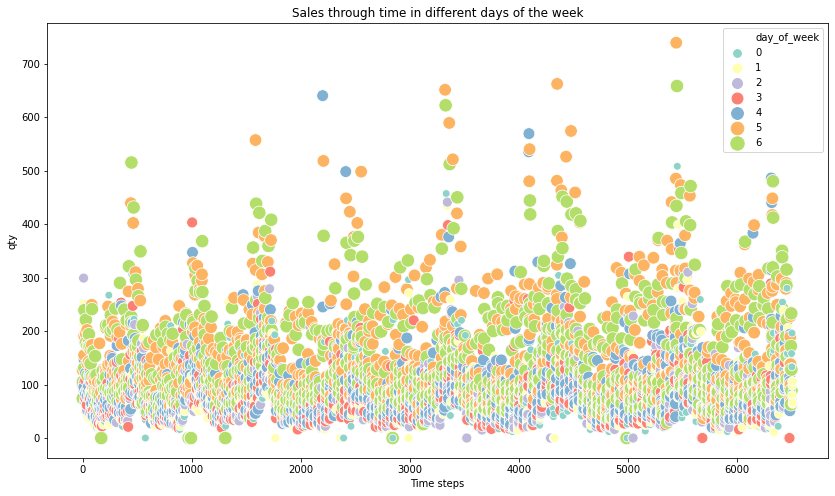

day_of_week          0    1    2    3    4    5    6
rolling_medianlbl                                   
-1                 789  729  529  480  368  141  389
 1                 143  203  398  450  562  791  543 

Running Chi-Square test...
(1269.4789703926167, 4.382012214792479e-271, 6, array([[489.96162701, 489.96162701, 487.33307751, 488.91020721,
        488.91020721, 489.96162701, 489.96162701],
       [442.03837299, 442.03837299, 439.66692249, 441.08979279,
        441.08979279, 442.03837299, 442.03837299]]))


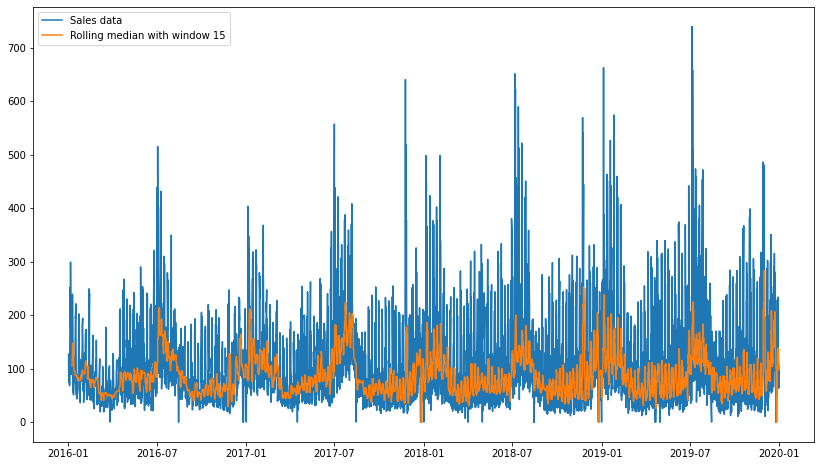

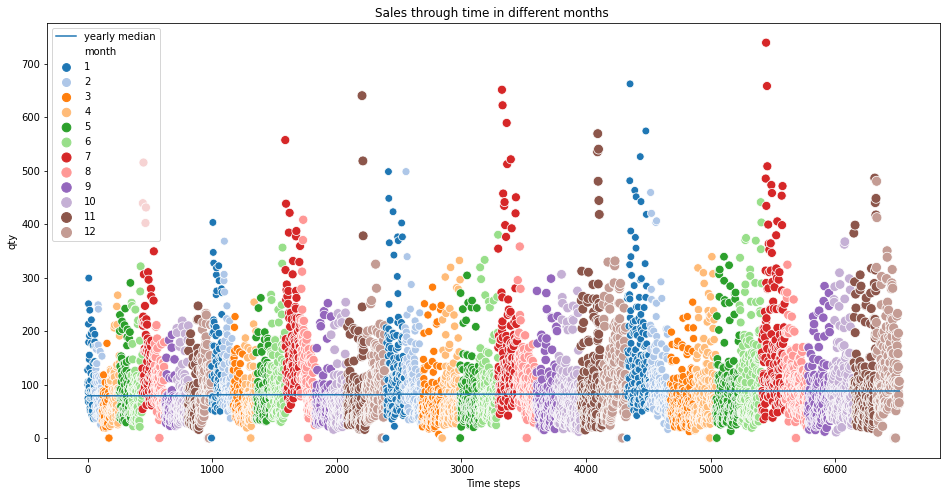

month         1    2    3    4    5    6    7    8    9    10   11   12
ymedian_lbl                                                            
-1           153  187  361  304  324  263   79  243  412  383  350  223
 1           341  263  135  193  224  277  479  315  146  213  250  397 

Running Chi-Square test...
(767.2550693424514, 2.0254741662255568e-157, 11, array([[248.85771297, 226.69224866, 249.86523408, 250.36899463,
        276.06078281, 272.03069839, 281.09838833, 281.09838833,
        281.09838833, 300.24128933, 302.25633154, 312.33154259],
       [245.14228703, 223.30775134, 246.13476592, 246.63100537,
        271.93921719, 267.96930161, 276.90161167, 276.90161167,
        276.90161167, 295.75871067, 297.74366846, 307.66845741]]))

Mean sales when the weather is rainy (-1) and when it is not (1) for the whole year:
              mean_qty  counts
conditions                    
-1          105.663167    2381
 1          101.150943    4134

Mean sales when the weather is rain

In [5]:
data_analysis_procedure(all_cc)

Shop 1
Starting data analysis...
Added rolling, yearly and monthly median signals, needed for statistical analysis.
Beginning plots and tests.



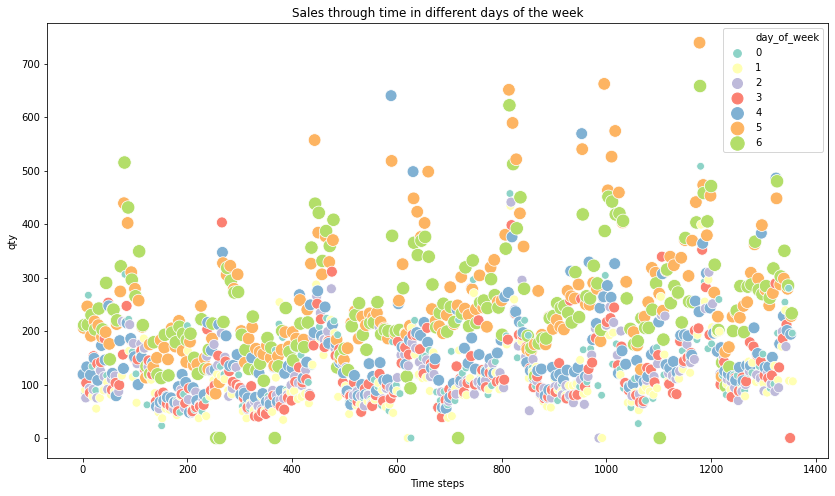

day_of_week          0    1    2    3    4    5    6
rolling_medianlbl                                   
-1                 136  158  150  148   92   16   22
 1                  58   36   43   46  102  178  172 

Running Chi-Square test...
(469.15643174542663, 3.6916741312385976e-98, 6, array([[103.21886514, 103.21886514, 102.68680914, 103.21886514,
        103.21886514, 103.21886514, 103.21886514],
       [ 90.78113486,  90.78113486,  90.31319086,  90.78113486,
         90.78113486,  90.78113486,  90.78113486]]))


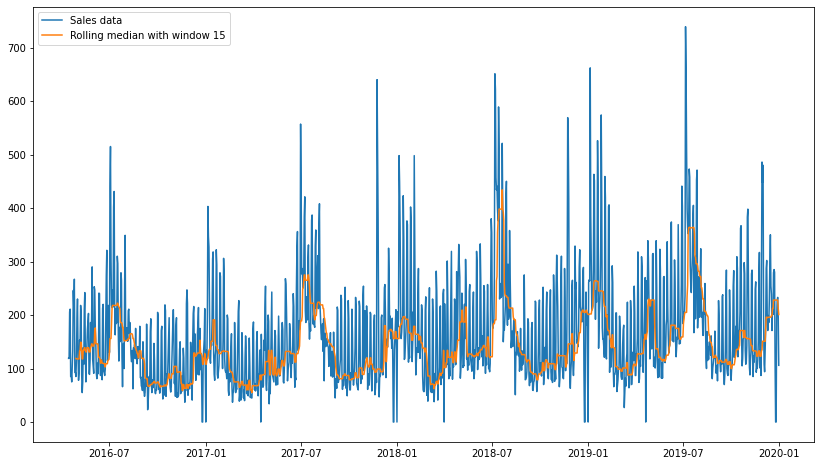

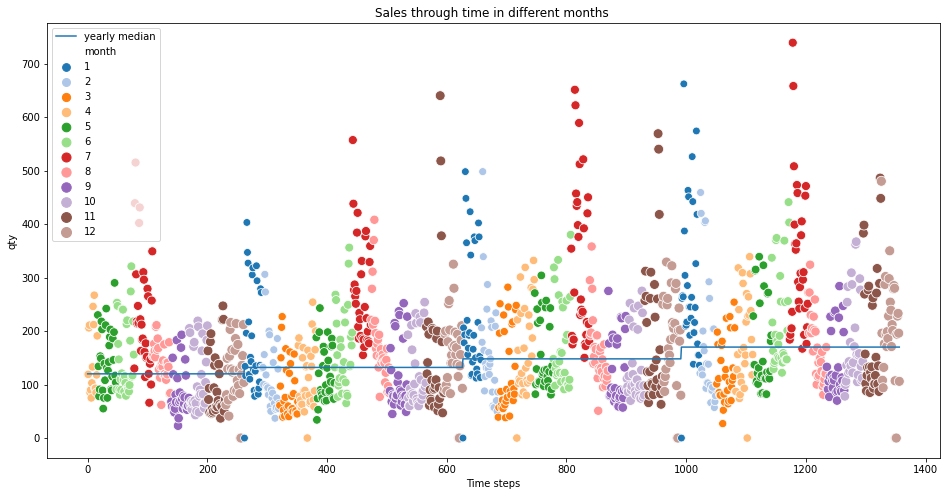

month        1   2   3   4   5   6    7   8   9   10  11  12
ymedian_lbl                                                 
-1           27  54  66  59  72  60    5  56  89  83  74  40
 1           66  30  27  48  52  60  119  68  31  41  46  84 

Running Chi-Square test...
(214.19170426604572, 8.364566302587672e-40, 11, array([[46.94546794, 42.40235814, 46.94546794, 54.01252763, 62.59395726,
        60.57479735, 62.59395726, 62.59395726, 60.57479735, 62.59395726,
        60.57479735, 62.59395726],
       [46.05453206, 41.59764186, 46.05453206, 52.98747237, 61.40604274,
        59.42520265, 61.40604274, 61.40604274, 59.42520265, 61.40604274,
        59.42520265, 61.40604274]]))

Mean sales when the weather is rainy (-1) and when it is not (1) for the whole year:
              mean_qty  counts
conditions                    
-1          176.530000     500
 1          162.509918     857

Mean sales when the weather is rainy (-1) and when it is not (1) without sale seasons:
              mea

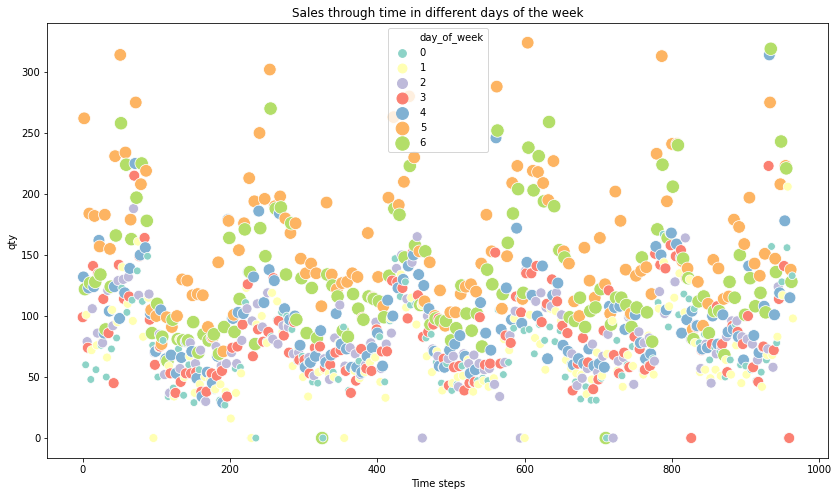

day_of_week          0    1   2    3   4    5    6
rolling_medianlbl                                 
-1                 120  122  89  101  66    8   15
 1                  18   16  48   37  72  130  123 

Running Chi-Square test...
(387.72506619834365, 1.2162133227446825e-80, 6, array([[74.50569948, 74.50569948, 73.96580311, 74.50569948, 74.50569948,
        74.50569948, 74.50569948],
       [63.49430052, 63.49430052, 63.03419689, 63.49430052, 63.49430052,
        63.49430052, 63.49430052]]))


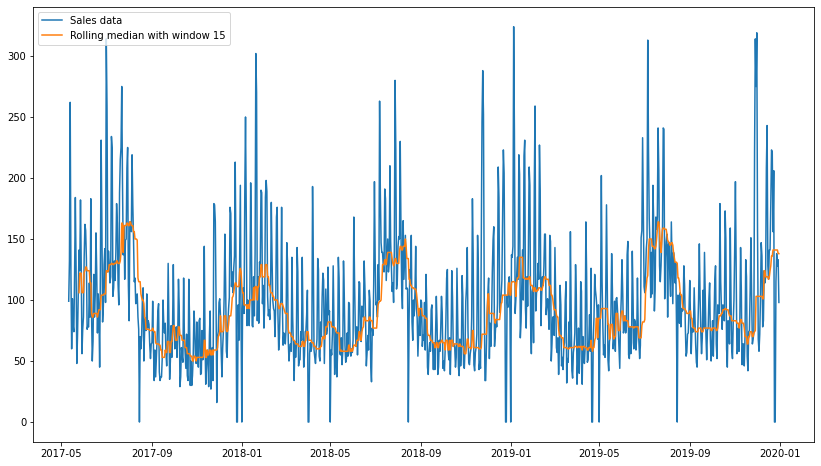

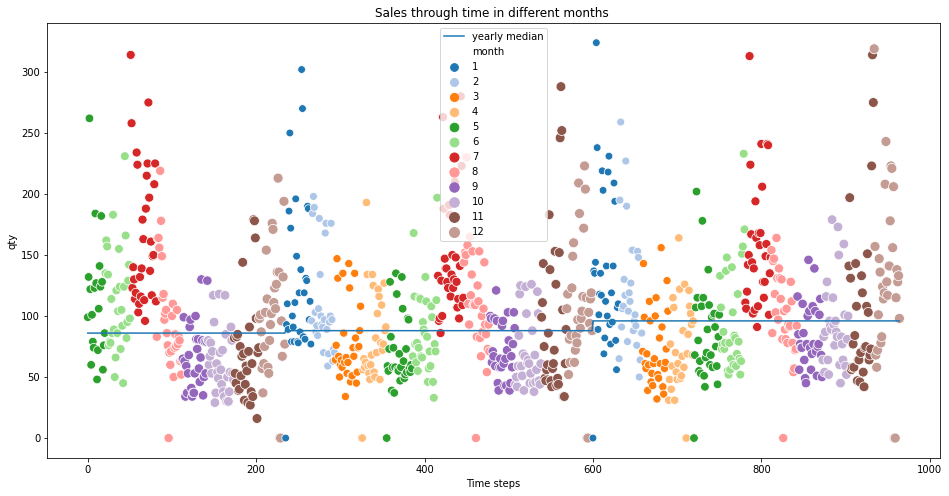

month        1   2   3   4   5   6   7   8   9   10  11  12
ymedian_lbl                                                
-1           18  19  47  42  51  47   2  41  64  72  58  29
 1           44  37  15  18  32  43  91  52  26  21  32  64 

Running Chi-Square test...
(198.31545908298708, 1.663087643020937e-36, 11, array([[31.48186528, 28.43523316, 31.48186528, 30.46632124, 42.14507772,
        45.69948187, 47.22279793, 47.22279793, 45.69948187, 47.22279793,
        45.69948187, 47.22279793],
       [30.51813472, 27.56476684, 30.51813472, 29.53367876, 40.85492228,
        44.30051813, 45.77720207, 45.77720207, 44.30051813, 45.77720207,
        44.30051813, 45.77720207]]))

Mean sales when the weather is rainy (-1) and when it is not (1) for the whole year:
              mean_qty  counts
conditions                    
-1          102.674157     356
 1           99.195402     609

Mean sales when the weather is rainy (-1) and when it is not (1) without sale seasons:
             mean_qty

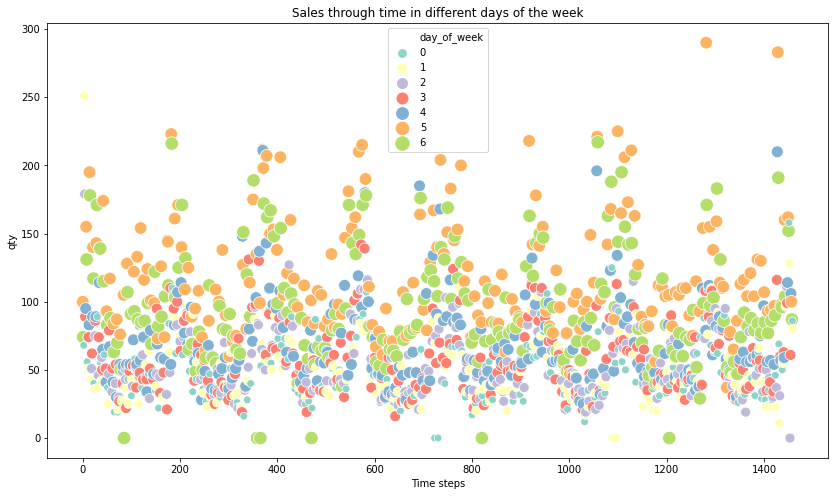

day_of_week          0    1    2    3    4    5    6
rolling_medianlbl                                   
-1                 169  175  159  147   97   10   36
 1                  40   34   49   61  111  199  173 

Running Chi-Square test...
(523.1596739207308, 8.606355527480473e-110, 6, array([[113.51849315, 113.51849315, 112.97534247, 112.97534247,
        112.97534247, 113.51849315, 113.51849315],
       [ 95.48150685,  95.48150685,  95.02465753,  95.02465753,
         95.02465753,  95.48150685,  95.48150685]]))


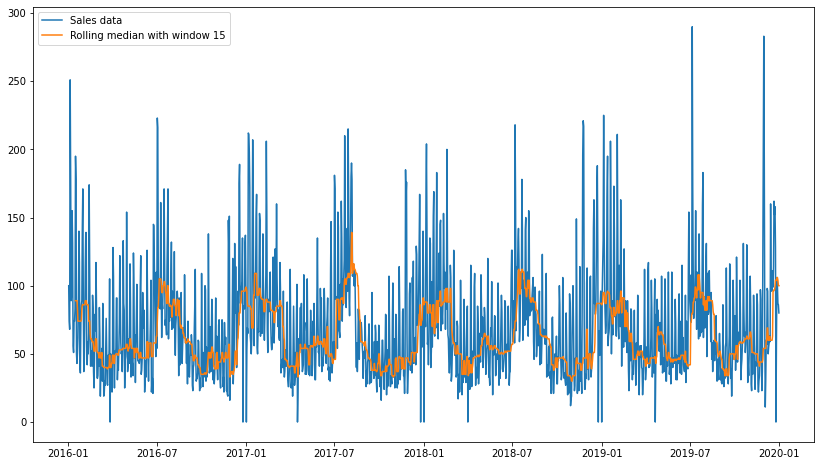

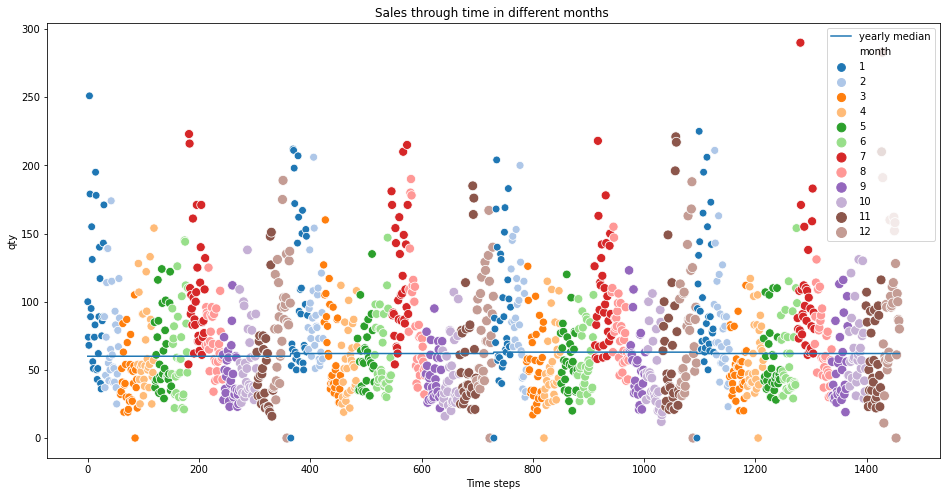

month        1   2   3   4   5   6    7   8   9   10  11  12
ymedian_lbl                                                 
-1           28  37  89  78  80  71    9  51  93  87  73  43
 1           95  76  35  42  44  49  115  73  27  37  47  81 

Running Chi-Square test...
(266.83174141371444, 8.271530729117965e-51, 11, array([[62.25821918, 57.19657534, 62.76438356, 60.73972603, 62.76438356,
        60.73972603, 62.76438356, 62.76438356, 60.73972603, 62.76438356,
        60.73972603, 62.76438356],
       [60.74178082, 55.80342466, 61.23561644, 59.26027397, 61.23561644,
        59.26027397, 61.23561644, 61.23561644, 59.26027397, 61.23561644,
        59.26027397, 61.23561644]]))

Mean sales when the weather is rainy (-1) and when it is not (1) for the whole year:
             mean_qty  counts
conditions                   
-1          71.790787     521
 1          71.073482     939

Mean sales when the weather is rainy (-1) and when it is not (1) without sale seasons:
             mean_qty

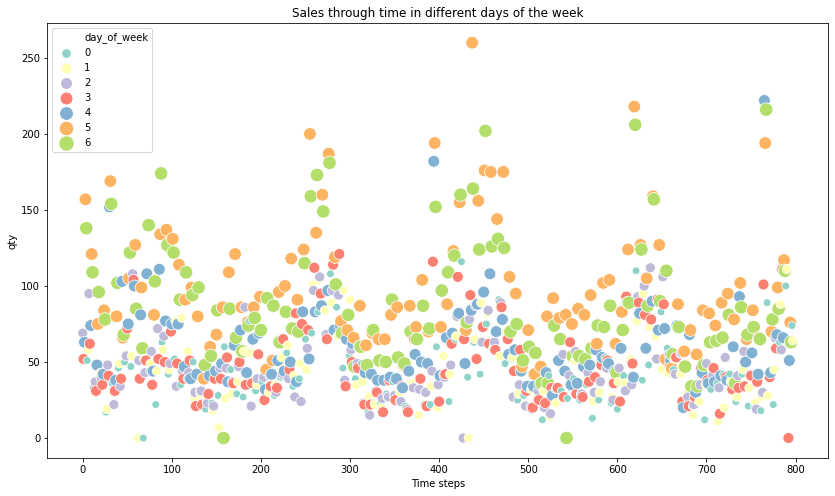

day_of_week         0   1   2   3   4    5   6
rolling_medianlbl                             
-1                 93  92  77  84  55    8  15
 1                 21  22  37  30  59  106  99 

Running Chi-Square test...
(272.28700433861366, 7.0302671162040795e-56, 6, array([[60.57142857, 60.57142857, 60.57142857, 60.57142857, 60.57142857,
        60.57142857, 60.57142857],
       [53.42857143, 53.42857143, 53.42857143, 53.42857143, 53.42857143,
        53.42857143, 53.42857143]]))


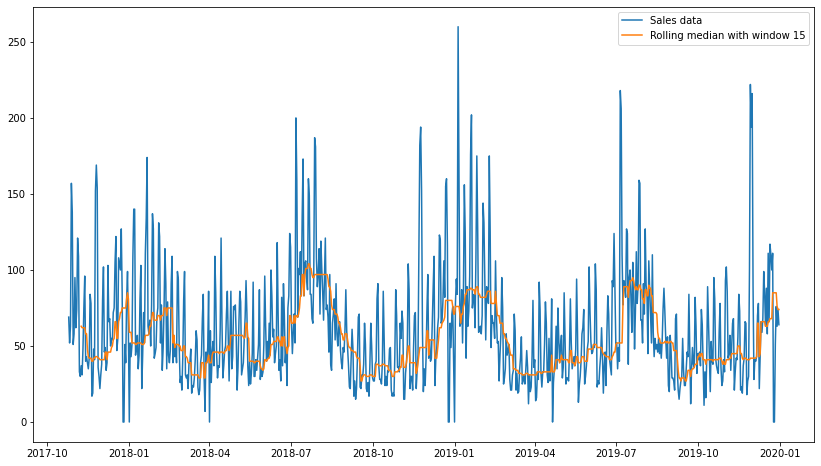

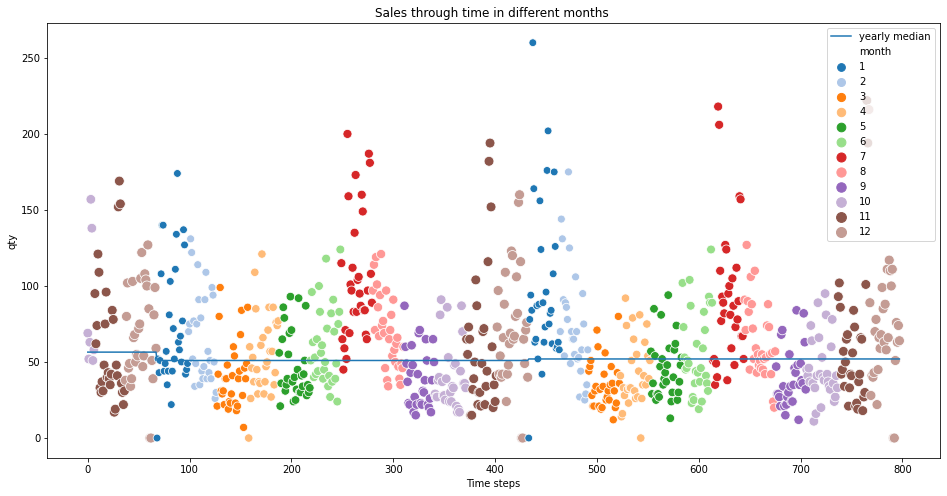

month        1   2   3   4   5   6   7   8   9   10  11  12
ymedian_lbl                                                
-1           16  20  51  36  42  31   9  21  47  49  51  33
 1           46  36  11  24  20  29  53  41  13  20  39  60 

Running Chi-Square test...
(133.53381493091507, 3.3495470741158955e-23, 11, array([[31.54385965, 28.49122807, 31.54385965, 30.52631579, 31.54385965,
        30.52631579, 31.54385965, 31.54385965, 30.52631579, 35.10526316,
        45.78947368, 47.31578947],
       [30.45614035, 27.50877193, 30.45614035, 29.47368421, 30.45614035,
        29.47368421, 30.45614035, 30.45614035, 29.47368421, 33.89473684,
        44.21052632, 45.68421053]]))

Mean sales when the weather is rainy (-1) and when it is not (1) for the whole year:
             mean_qty  counts
conditions                   
 1          62.586420     486
-1          59.522436     312

Mean sales when the weather is rainy (-1) and when it is not (1) without sale seasons:
             mean_qty  c

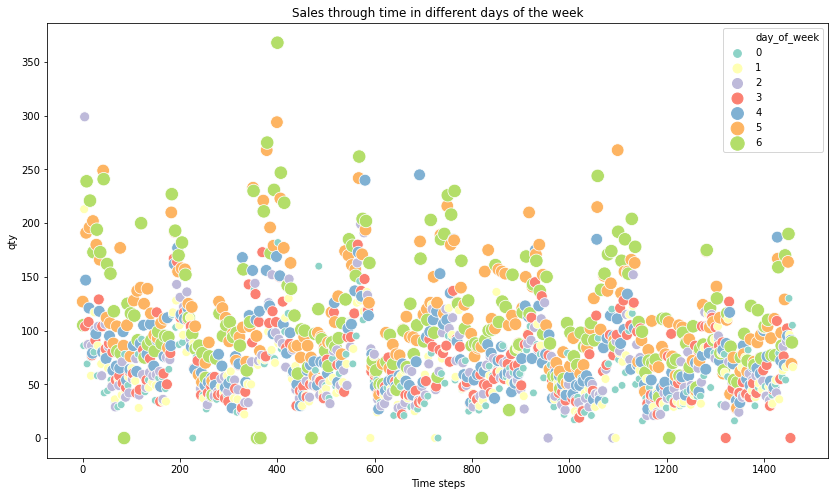

day_of_week          0    1    2    3    4    5    6
rolling_medianlbl                                   
-1                 174  165  156  136  103   23   36
 1                  35   44   52   72  105  186  173 

Running Chi-Square test...
(443.56705799865733, 1.1895483288733445e-92, 6, array([[113.51849315, 113.51849315, 112.97534247, 112.97534247,
        112.97534247, 113.51849315, 113.51849315],
       [ 95.48150685,  95.48150685,  95.02465753,  95.02465753,
         95.02465753,  95.48150685,  95.48150685]]))


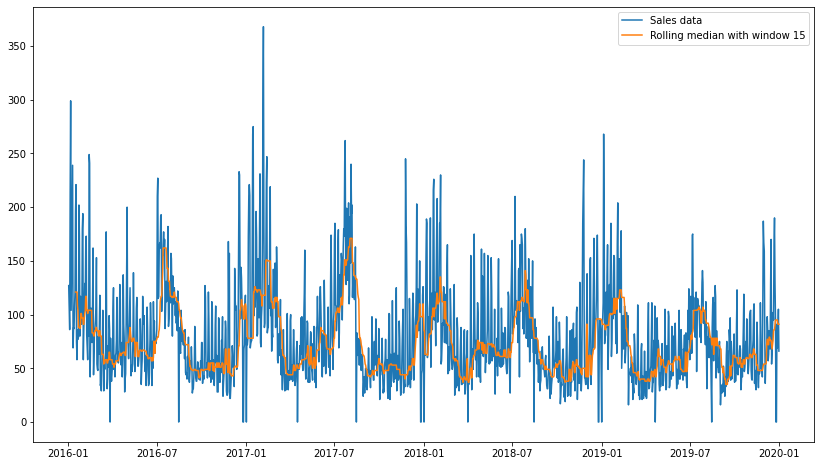

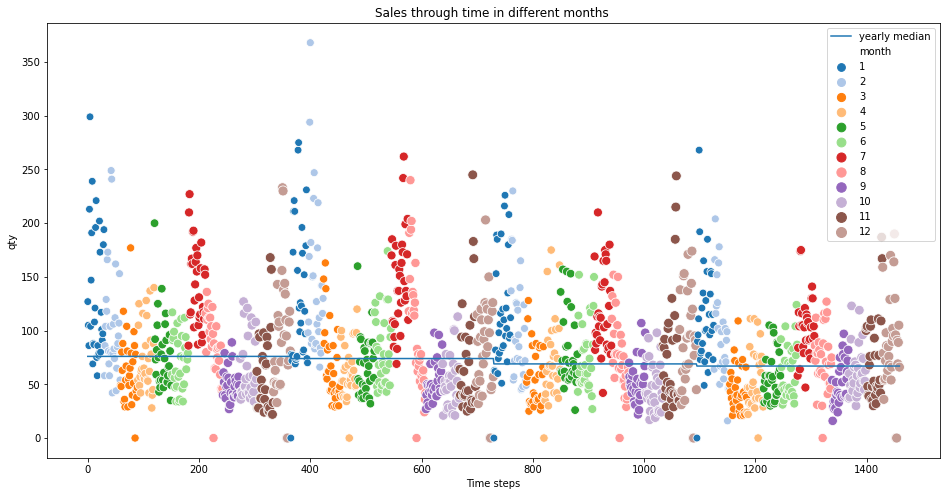

month         1   2   3   4   5   6    7   8    9   10  11  12
ymedian_lbl                                                   
-1            17  26  89  78  77  66    5  53  102  96  75  48
 1           106  87  35  42  47  54  119  71   18  28  45  76 

Running Chi-Square test...
(357.425753105339, 6.498907502162539e-70, 11, array([[61.66849315, 56.65479452, 62.16986301, 60.16438356, 62.16986301,
        60.16438356, 62.16986301, 62.16986301, 60.16438356, 62.16986301,
        60.16438356, 62.16986301],
       [61.33150685, 56.34520548, 61.83013699, 59.83561644, 61.83013699,
        59.83561644, 61.83013699, 61.83013699, 59.83561644, 61.83013699,
        59.83561644, 61.83013699]]))

Mean sales when the weather is rainy (-1) and when it is not (1) for the whole year:
             mean_qty  counts
conditions                   
-1          82.188100     521
 1          81.040469     939

Mean sales when the weather is rainy (-1) and when it is not (1) without sale seasons:
             me

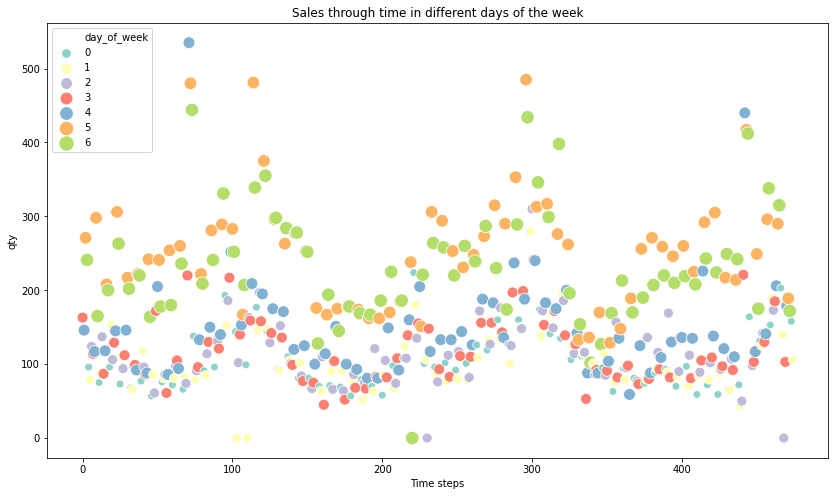

day_of_week         0   1   2   3   4   5   6
rolling_medianlbl                            
-1                 57  57  49  50  27   4   3
 1                 11  11  18  18  41  64  65 

Running Chi-Square test...
(203.55603205691, 3.320326837251947e-41, 6, array([[35.36, 35.36, 34.84, 35.36, 35.36, 35.36, 35.36],
       [32.64, 32.64, 32.16, 32.64, 32.64, 32.64, 32.64]]))


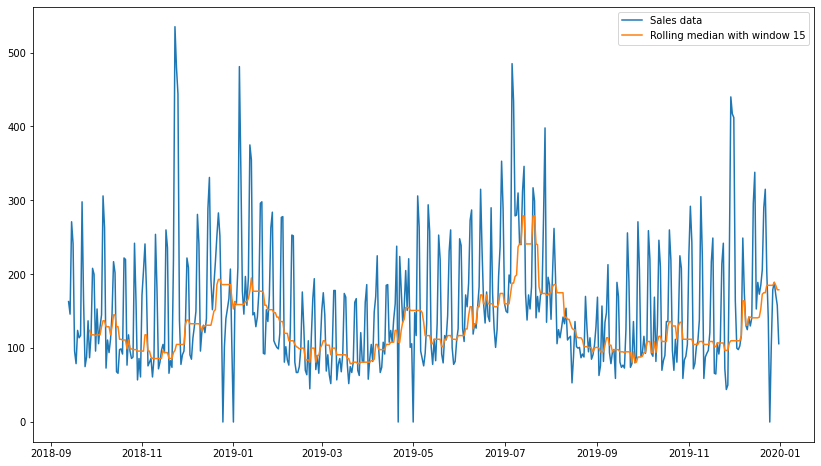

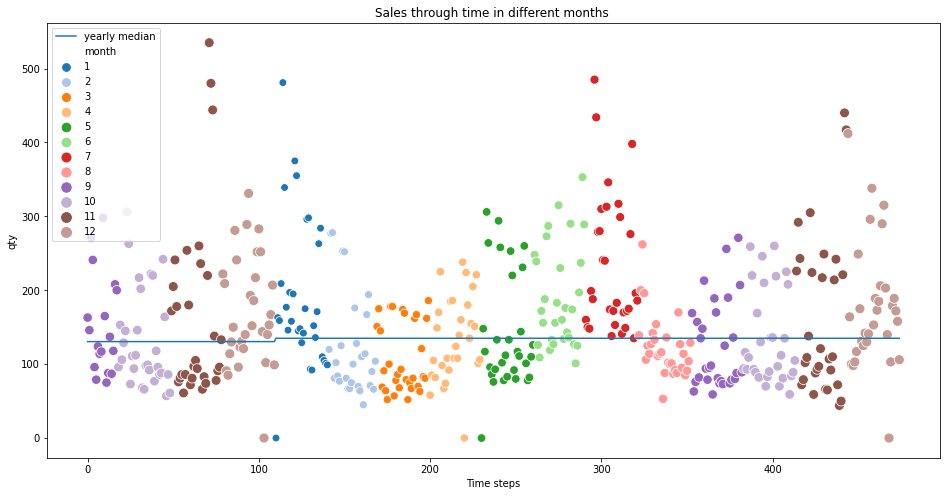

month        1   2   3   4   5   6   7   8   9   10  11  12
ymedian_lbl                                                
-1            8  21  20  16  21   9   1  23  28  40  33  20
 1           23   7  11  14  10  21  30   8  20  22  27  42 

Running Chi-Square test...
(75.01589548539619, 1.3459507463180485e-11, 11, array([[15.66315789, 14.14736842, 15.66315789, 15.15789474, 15.66315789,
        15.15789474, 15.66315789, 15.66315789, 24.25263158, 31.32631579,
        30.31578947, 31.32631579],
       [15.33684211, 13.85263158, 15.33684211, 14.84210526, 15.33684211,
        14.84210526, 15.33684211, 15.33684211, 23.74736842, 30.67368421,
        29.68421053, 30.67368421]]))

Mean sales when the weather is rainy (-1) and when it is not (1) for the whole year:
              mean_qty  counts
conditions                    
-1          163.584795     171
 1          148.766447     304

Mean sales when the weather is rainy (-1) and when it is not (1) without sale seasons:
              mean_qt

In [6]:
for shop_nr, shop in enumerate(shop_list):
    print("Shop", shop_nr+1)
    data_analysis_procedure(shop)
    print("\n\n")

In [114]:
from scipy.stats import ttest_ind

for shop_nr, shop in enumerate(shop_list):
    print("Shop", shop_nr+1)
    
    no_sales_global_data_df = shop.copy(deep=True)
    no_sales_global_data_df = shop.drop(shop[shop.index.month.isin([1, 2, 7, 8, 12])].index, axis=0) 
    
    years_in_df = no_sales_global_data_df.index.year.unique().tolist()
    for year in years_in_df:
        yearly_data = no_sales_global_data_df.loc[str(year)]
        total_rainy_sample = yearly_data[yearly_data.conditions == -1].qty.values
        total_non_rainy_sample = yearly_data[yearly_data.conditions == 1].qty.values

        print("Welch T-test comparing global sales in non-rainy and rainy days in", year)
        print("Non rainy #:", len(total_non_rainy_sample), "Rainy #:", len(total_rainy_sample))
        print(ttest_ind(total_non_rainy_sample,total_rainy_sample, equal_var=False))
        print()

Shop 1
Welch T-test comparing global sales in non-rainy and rainy days in 2016
Non rainy #: 105 Rainy #: 64
Ttest_indResult(statistic=-0.5508675746347619, pvalue=0.582764450618291)

Welch T-test comparing global sales in non-rainy and rainy days in 2017
Non rainy #: 148 Rainy #: 65
Ttest_indResult(statistic=-2.357803093966738, pvalue=0.020652021294637203)

Welch T-test comparing global sales in non-rainy and rainy days in 2018
Non rainy #: 113 Rainy #: 100
Ttest_indResult(statistic=-1.182898087806885, pvalue=0.23835399871813887)

Welch T-test comparing global sales in non-rainy and rainy days in 2019
Non rainy #: 123 Rainy #: 90
Ttest_indResult(statistic=-0.7701528842222131, pvalue=0.44216096501993873)

Shop 2
Welch T-test comparing global sales in non-rainy and rainy days in 2017
Non rainy #: 109 Rainy #: 33
Ttest_indResult(statistic=-2.4589097541405813, pvalue=0.017509272225115842)

Welch T-test comparing global sales in non-rainy and rainy days in 2018
Non rainy #: 104 Rainy #: 109


Welch T-test comparing spring-summer sales 2017 on Mondays
Non rainy #: 5 Rainy #: 2
Non rainy mean: 57.4 Rainy mean: 79.0
Ttest_indResult(statistic=-2.839942695287276, pvalue=0.03624889012355996)

Welch T-test comparing spring-summer sales 2017 on Tuesdays
Non rainy #: 5 Rainy #: 2
Non rainy mean: 84.0 Rainy mean: 87.0
Ttest_indResult(statistic=-0.21505514481979618, pvalue=0.8382209071358752)

Welch T-test comparing spring-summer sales 2017 on Wednesdays
Non rainy #: 5 Rainy #: 2
Non rainy mean: 88.2 Rainy mean: 125.0
Ttest_indResult(statistic=-4.168062163683311, pvalue=0.00875544981299405)

Welch T-test comparing spring-summer sales 2017 on Thursdays
Non rainy #: 5 Rainy #: 3
Non rainy mean: 92.0 Rainy mean: 125.33333333333333
Ttest_indResult(statistic=-1.3847635376576093, pvalue=0.21541880068361333)
Varinaces: Non rainy: 1090.8 Rainy mean: 354.8888888888889

Welch T-test comparing spring-summer sales 2017 on Fridays
Non rainy #: 4 Rainy #: 4
Non rainy mean: 109.5 Rainy mean: 128.75


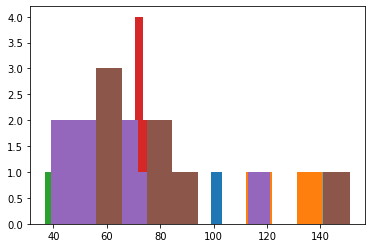

In [145]:
no_sales_data_df = turin_cc_beina_data.copy(deep=True)
#no_sales_data_df = turin_cc_juve_data.drop(turin_cc_juve_data[turin_cc_juve_data.index.month.isin([1, 2, 7, 8])].index, axis=0)

years_in_df = no_sales_data_df.index.year.unique().tolist()
spring_summer = [3,4,5,6]
autumn_winter = [9,10,11,12]
for year in years_in_df:
    yearly_data = no_sales_data_df.loc[str(year)]
    #first_rainy_sample = first_season[first_season.conditions == -1].qty.values
    #first_non_rainy_sample = first_season[first_season.conditions == 1].qty.values
    #second_rainy_sample = second_season[second_season.conditions == -1].qty.values
    #second_non_rainy_sample = second_season[second_season.conditions == 1].qty.values
    
    first_season = yearly_data[yearly_data.index.month.isin(spring_summer)]
    
    first_mon = first_season[first_season.index.dayofweek == 0]
    first_rainy_mon = first_mon[first_mon.conditions == -1].qty.values
    first_non_rainy_mon = first_mon[first_mon.conditions == 1].qty.values
    print("Welch T-test comparing spring-summer sales", year, "on Mondays")
    print("Non rainy #:", len(first_non_rainy_mon), "Rainy #:", len(first_rainy_mon))
    print("Non rainy mean:", np.mean(first_non_rainy_mon), "Rainy mean:", np.mean(first_rainy_mon))
    print(ttest_ind(first_non_rainy_mon, first_rainy_mon, equal_var=True))
    print()
    first_tue = first_season[first_season.index.dayofweek == 1]
    first_rainy_tue = first_tue[first_tue.conditions == -1].qty.values
    first_non_rainy_tue = first_tue[first_tue.conditions == 1].qty.values
    print("Welch T-test comparing spring-summer sales", year, "on Tuesdays")
    print("Non rainy #:", len(first_non_rainy_tue), "Rainy #:", len(first_rainy_tue))
    print("Non rainy mean:", np.mean(first_non_rainy_tue), "Rainy mean:", np.mean(first_rainy_tue))
    print(ttest_ind(first_non_rainy_tue, first_rainy_tue, equal_var=True))
    print()
    first_wed = first_season[first_season.index.dayofweek == 2]
    first_rainy_wed = first_wed[first_wed.conditions == -1].qty.values
    first_non_rainy_wed = first_wed[first_wed.conditions == 1].qty.values
    print("Welch T-test comparing spring-summer sales", year, "on Wednesdays")
    print("Non rainy #:", len(first_non_rainy_wed), "Rainy #:", len(first_rainy_wed))
    print("Non rainy mean:", np.mean(first_non_rainy_wed), "Rainy mean:", np.mean(first_rainy_wed))
    print(ttest_ind(first_non_rainy_wed, first_rainy_wed, equal_var=True))
    print()    
    first_thu = first_season[first_season.index.dayofweek == 3]
    first_rainy_thu = first_thu[first_thu.conditions == -1].qty.values
    first_non_rainy_thu = first_thu[first_thu.conditions == 1].qty.values
    print("Welch T-test comparing spring-summer sales", year, "on Thursdays")
    print("Non rainy #:", len(first_non_rainy_thu), "Rainy #:", len(first_rainy_thu))
    print("Non rainy mean:", np.mean(first_non_rainy_thu), "Rainy mean:", np.mean(first_rainy_thu))
    print(ttest_ind(first_non_rainy_thu, first_rainy_thu, equal_var=True))
    print("Varinaces:", "Non rainy:", (np.std(first_non_rainy_thu))**2, "Rainy:", (np.std(first_rainy_thu))**2)
    print()    
    first_fri = first_season[first_season.index.dayofweek == 4]
    first_rainy_fri = first_fri[first_fri.conditions == -1].qty.values
    first_non_rainy_fri = first_fri[first_fri.conditions == 1].qty.values
    print("Welch T-test comparing spring-summer sales", year, "on Fridays")
    print("Non rainy #:", len(first_non_rainy_fri), "Rainy #:", len(first_rainy_fri))
    print("Non rainy mean:", np.mean(first_non_rainy_fri), "Rainy mean:", np.mean(first_rainy_fri))
    print(ttest_ind(first_non_rainy_fri, first_rainy_fri, equal_var=True))
    print()    
    first_sat = first_season[first_season.index.dayofweek == 5]
    first_rainy_sat = first_sat[first_sat.conditions == -1].qty.values
    first_non_rainy_sat = first_sat[first_sat.conditions == 1].qty.values
    print("Welch T-test comparing spring-summer sales", year, "on Saturdays")
    print("Non rainy #:", len(first_non_rainy_sat), "Rainy #:", len(first_rainy_sat))
    print("Non rainy mean:", np.mean(first_non_rainy_sat), "Rainy mean:", np.mean(first_rainy_sat))
    print(ttest_ind(first_non_rainy_sat, first_rainy_sat, equal_var=True))
    print()    
    first_sun = first_season[first_season.index.dayofweek == 6]
    first_rainy_sun = first_sun[first_sun.conditions == -1].qty.values
    first_non_rainy_sun = first_sun[first_sun.conditions == 1].qty.values
    print("Welch T-test comparing spring-summer sales", year, "on Sundays")
    print("Non rainy #:", len(first_non_rainy_sun), "Rainy #:", len(first_rainy_sun))
    print("Non rainy mean:", np.mean(first_non_rainy_sun), "Rainy mean:", np.mean(first_rainy_sun))
    print(ttest_ind(first_non_rainy_sun, first_rainy_sun, equal_var=True))
    print("\n\n")    

    
    
    second_season = yearly_data[yearly_data.index.month.isin(autumn_winter)]
    
    second_mon = second_season[second_season.index.dayofweek == 0]
    second_rainy_mon = second_mon[second_mon.conditions == -1].qty.values
    second_non_rainy_mon = second_mon[second_mon.conditions == 1].qty.values
    print("Welch T-test comparing autumn-winter sales", year, "on Mondays")
    print("Non rainy #:", len(second_non_rainy_mon), "Rainy #:", len(second_rainy_mon))
    print("Non rainy mean:", np.mean(second_non_rainy_mon), "Rainy mean:", np.mean(second_rainy_mon))
    print(ttest_ind(second_non_rainy_mon, second_rainy_mon, equal_var=True))
    print()    
    second_tue = second_season[second_season.index.dayofweek == 1]
    second_rainy_tue = second_tue[second_tue.conditions == -1].qty.values
    second_non_rainy_tue = second_tue[second_tue.conditions == 1].qty.values
    print("Welch T-test comparing autumn-winter sales", year, "on Tuesdays")
    print("Non rainy #:", len(second_non_rainy_tue), "Rainy #:", len(second_rainy_tue))
    print("Non rainy mean:", np.mean(second_non_rainy_tue), "Rainy mean:", np.mean(second_rainy_tue))
    print(ttest_ind(second_non_rainy_tue, second_rainy_tue, equal_var=True))
    print()
    second_wed = second_season[second_season.index.dayofweek == 2]
    second_rainy_wed = second_wed[second_wed.conditions == -1].qty.values
    second_non_rainy_wed = second_wed[second_wed.conditions == 1].qty.values
    print("Welch T-test comparing autumn-winter sales", year, "on Wednesdays")
    print("Non rainy #:", len(second_non_rainy_wed), "Rainy #:", len(second_rainy_wed))
    print("Non rainy mean:", np.mean(second_non_rainy_wed), "Rainy mean:", np.mean(second_rainy_wed))
    print(ttest_ind(second_non_rainy_wed, second_rainy_wed, equal_var=True))
    print()
    second_thu = second_season[second_season.index.dayofweek == 3]
    second_rainy_thu = second_thu[second_thu.conditions == -1].qty.values
    second_non_rainy_thu = second_thu[second_thu.conditions == 1].qty.values
    print("Welch T-test comparing autumn-winter sales", year, "on Thursdays")
    print("Non rainy #:", len(second_non_rainy_thu), "Rainy #:", len(second_rainy_thu))
    print("Non rainy mean:", np.mean(second_non_rainy_thu), "Rainy mean:", np.mean(second_rainy_thu))
    print(ttest_ind(second_non_rainy_thu, second_rainy_thu, equal_var=True))
    print()  
    second_fri = second_season[second_season.index.dayofweek == 4]
    second_rainy_fri = second_fri[second_fri.conditions == -1].qty.values
    second_non_rainy_fri = second_fri[second_fri.conditions == 1].qty.values
    print("Welch T-test comparing autumn-winter sales", year, "on Fridays")
    print("Non rainy #:", len(second_non_rainy_fri), "Rainy #:", len(second_rainy_fri))
    print("Non rainy mean:", np.mean(second_non_rainy_fri), "Rainy mean:", np.mean(second_rainy_fri))
    print(ttest_ind(second_non_rainy_fri, second_rainy_fri, equal_var=True))
    print()
    second_sat = second_season[second_season.index.dayofweek == 5]
    second_rainy_sat = second_sat[second_sat.conditions == -1].qty.values
    second_non_rainy_sat = second_sat[second_sat.conditions == 1].qty.values
    print("Welch T-test comparing autumn-winter sales", year, "on Saturdays")
    print("Non rainy #:", len(second_non_rainy_sat), "Rainy #:", len(second_rainy_sat))
    print("Non rainy mean:", np.mean(second_non_rainy_sat), "Rainy mean:", np.mean(second_rainy_sat))
    print(ttest_ind(second_non_rainy_sat, second_rainy_sat, equal_var=True))
    print()
    second_sun = second_season[second_season.index.dayofweek == 6]
    second_rainy_sun = second_sun[second_sun.conditions == -1].qty.values
    second_non_rainy_sun = second_sun[second_sun.conditions == 1].qty.values
    print("Welch T-test comparing autumn-winter sales", year, "on Sundays")
    print("Non rainy #:", len(second_non_rainy_sun), "Rainy #:", len(second_rainy_sun))
    print("Non rainy mean:", np.mean(second_non_rainy_sun), "Rainy mean:", np.mean(second_rainy_sun))
    print(ttest_ind(second_non_rainy_sun, second_rainy_sun, equal_var=True))
    print("\n\n\n")
    
    """
        Put together mon tue wed thu | fri sat sun
    """

In [ ]:
shop_list = [milan_cc_arese_data, turin_cc_beina_data, turin_cc_juve_data, \
            turin_cc_niche_data, turin_cc_torin_data, rome_cc_eur2_data]

In [159]:
all_turin_cc = pd.concat([turin_cc_beina_data, turin_cc_niche_data, turin_cc_juve_data, turin_cc_torin_data], axis=0)
all_turin_cc.sort_index(inplace=True)
all_turin_cc

qty       sin_day   cos_day    sincos_day  day_of_week  TMEDIA °C  \
time                                                                            
2016-01-02  100  3.442161e-02  0.999407  3.440121e-02            5        3.0   
2016-01-02  127  3.442161e-02  0.999407  3.440121e-02            5        3.0   
2016-01-03  105  5.161967e-02  0.998667  5.155085e-02            6        2.0   
2016-01-03   74  5.161967e-02  0.998667  5.155085e-02            6        2.0   
2016-01-04   86  6.880243e-02  0.997630  6.863939e-02            0        1.0   
...         ...           ...       ...           ...          ...        ...   
2019-12-30   86 -1.721336e-02  0.999852 -1.721081e-02            0        2.0   
2019-12-31   98 -2.449294e-16  1.000000 -2.449294e-16            1        2.0   
2019-12-31   80 -2.449294e-16  1.000000 -2.449294e-16            1        2.0   
2019-12-31   64 -2.449294e-16  1.000000 -2.449294e-16            1        2.0   
2019-12-31   66 -2.449294e-16  1.000000 -2.449294e-16            1        2.0   

            TMIN °C  TMAX °C  PUNTORUGIADA °C  UMIDITA %  ...  \
time                                                      ...   
2016-01-02      2.0      4.0              2.0       92.0  ...   
2016-01-02      2.0      4.0              2.0       92.0  ...   
2016-01-03      1.0      2.0              1.0       95.0  ...   
2016-01-03      1.0      2.0              1.0       95.0  ...   
2016-01-04      0.0      2.0              1.0       93.0  ...   
...             ...      ...              ...        ...  ...   
2019-12-30     -1.0      4.0              2.0       96.0  ...   
2019-12-31     -2.0     10.0              1.0       81.0  ...   
2019-12-31     -2.0     10.0              1.0       81.0  ...   
2019-12-31     -2.0     10.0              1.0       81.0  ...   
2019-12-31     -2.0     10.0              1.0       81.0  ...   

            VENTOMEDIA km/h  VENTOMAX km/h  RAFFICA km/h  PRESSIONESLM mb  \
time                                                                        
2016-01-02              4.0           11.0           0.0           1018.0   
2016-01-02              4.0           11.0           0.0           1018.0   
2016-01-03              6.0           11.0           0.0           1009.0   
2016-01-03              6.0           11.0           0.0           1009.0   
2016-01-04              5.0            9.0           0.0           1000.0   
...                     ...            ...           ...              ...   
2019-12-30              5.0           11.0           0.0           1036.0   
2019-12-31              4.0            9.0           0.0           1030.0   
2019-12-31              4.0            9.0           0.0           1030.0   
2019-12-31              4.0            9.0           0.0           1030.0   
2019-12-31              4.0            9.0           0.0           1030.0   

            conditions  rolling_medianlbl  yearly_median  month  \
time                                                              
2016-01-02          -1                  1           60.0      1   
2016-01-02          -1                  1           76.0      1   
2016-01-03           1                 -1           76.0      1   
2016-01-03           1                 -1           60.0      1   
2016-01-04          -1                 -1           76.0      1   
...                ...                ...            ...    ...   
2019-12-30          -1                 -1           62.0     12   
2019-12-31           1                 -1           96.0     12   
2019-12-31           1                 -1           62.0     12   
2019-12-31           1                 -1           52.0     12   
2019-12-31           1                 -1           67.0     12   

            monthly_median  ymedian_lbl  
time                                     
2016-01-02            87.5            1  
2016-01-02           106.5            1  
2016-01-03           106.5            1  
2016-01-03            87.5  

In [210]:
no_sales_data_df = milan_cc_arese_data.copy(deep=True)
np.random.seed(21)

years_in_df = no_sales_data_df.index.year.unique().tolist()
spring_summer = [3,4,5,6]
autumn_winter = [9,10,11,12]
for year in years_in_df:
    yearly_data = no_sales_data_df.loc[str(year)]

    first_season = yearly_data[yearly_data.index.month.isin(spring_summer)]
    
    first_workday = first_season[(first_season.index.dayofweek == 0) | (first_season.index.dayofweek == 1) | \
                             (first_season.index.dayofweek == 2) | (first_season.index.dayofweek == 3)]
   
    ## resampling
    first_rainy_work = first_workday[first_workday.conditions == -1].qty
    first_non_rainy_work = first_workday[first_workday.conditions == 1].qty
    if(len(first_rainy_work) > len(first_non_rainy_work)):
        first_rainy_work = first_rainy_work[:len(first_non_rainy_work)]
    else:
        first_non_rainy_work = first_non_rainy_work[:len(first_rainy_work)]

    print("spring-summer sales", year, "on work days")
    print("Non rainy #:", len(first_non_rainy_work), "Rainy #:", len(first_rainy_work))
    print("Non rainy mean:", np.mean(first_non_rainy_work), "Rainy mean:", np.mean(first_rainy_work))
    print("Non rainy var:", np.std(first_non_rainy_work)**2, "Rainy var:", np.std(first_rainy_work)**2)
    first_rainy_work_var = np.std(first_rainy_work)**2
    first_non_rainy_work_var = np.std(first_non_rainy_work)**2
    if(first_rainy_work_var > 2*first_non_rainy_work_var or first_non_rainy_work_var > 2*first_rainy_work_var):
        print("Welch", ttest_ind(first_non_rainy_work, first_rainy_work, equal_var=False))
    else:
        print("Student's", ttest_ind(first_non_rainy_work, first_rainy_work, equal_var=True))

    print()
    
    first_offday = first_season[(first_season.index.dayofweek == 4) | (first_season.index.dayofweek == 5) | \
                             (first_season.index.dayofweek == 6)]

    first_rainy_off = first_offday[first_offday.conditions == -1].qty
    first_non_rainy_off = first_offday[first_offday.conditions == 1].qty
    if(len(first_rainy_off) > len(first_non_rainy_off)):
        first_rainy_off = first_rainy_off[:len(first_non_rainy_off)]
    else:
        first_non_rainy_off = first_non_rainy_off[:len(first_rainy_off)]
        
    print("spring-summer sales", year, "on off days")
    print("Non rainy #:", len(first_non_rainy_off), "Rainy #:", len(first_rainy_off))
    print("Non rainy mean:", np.mean(first_non_rainy_off), "Rainy mean:", np.mean(first_rainy_off))
    print("Non rainy var:", np.std(first_non_rainy_off)**2, "Rainy var:", np.std(first_rainy_off)**2)
    first_rainy_off_var = np.std(first_rainy_off)**2
    first_non_rainy_off_var = np.std(first_non_rainy_off)**2
    if(first_rainy_off_var > 2*first_non_rainy_off_var or first_non_rainy_off_var > 2*first_rainy_off_var):
        print("Welch", ttest_ind(first_non_rainy_off, first_rainy_off, equal_var=False))
    else:
        print("Student's", ttest_ind(first_non_rainy_off, first_rainy_off, equal_var=True))
    print()
    
    ##########################################################################################################
    
    second_season = yearly_data[yearly_data.index.month.isin(autumn_winter)]
    
    second_workday = second_season[(second_season.index.dayofweek == 0) | (second_season.index.dayofweek == 1) | \
                             (second_season.index.dayofweek == 2) | (second_season.index.dayofweek == 3)]
    
    second_rainy_work = second_workday[second_workday.conditions == -1].qty
    second_non_rainy_work = second_workday[second_workday.conditions == 1].qty
    if(len(second_rainy_work) > len(second_non_rainy_work)):
        second_rainy_work = second_rainy_work[:len(second_non_rainy_work)]
    else:
        second_non_rainy_work = second_non_rainy_work[:len(second_rainy_work)]

    print("Welch T-test comparing autumn-winter sales", year, "on work days")
    print("Non rainy #:", len(second_non_rainy_work), "Rainy #:", len(second_rainy_work))
    print("Non rainy mean:", np.mean(second_non_rainy_work), "Rainy mean:", np.mean(second_rainy_work))
    print("Non rainy var:", np.std(second_non_rainy_work)**2, "Rainy var:", np.std(second_rainy_work)**2)
    second_rainy_work_var = np.std(second_rainy_work)**2
    second_non_rainy_work_var = np.std(second_non_rainy_work)**2
    if(second_rainy_work_var > 2*second_non_rainy_work_var or second_non_rainy_work_var > 2*second_rainy_work_var):
        print("Welch", ttest_ind(second_non_rainy_work, second_rainy_work, equal_var=False))
    else:
        print("Student's", ttest_ind(second_non_rainy_work, second_rainy_work, equal_var=True))
    print()
    
    second_offday = second_season[(second_season.index.dayofweek == 4) | (second_season.index.dayofweek == 5) | \
                            (second_season.index.dayofweek == 6)]
  
    second_rainy_off = second_offday[second_offday.conditions == -1].qty
    second_non_rainy_off = second_offday[second_offday.conditions == 1].qty
    if(len(second_rainy_off) > len(second_non_rainy_off)):
        second_rainy_off = second_rainy_off[:len(second_non_rainy_off)]
    else:
        second_non_rainy_off = second_non_rainy_off[:len(second_rainy_off)]


    print("Welch T-test comparing autumn-winter sales", year, "on off days")
    print("Non rainy #:", len(second_non_rainy_off), "Rainy #:", len(second_rainy_off))
    print("Non rainy mean:", np.mean(second_non_rainy_off), "Rainy mean:", np.mean(second_rainy_off))
    print("Non rainy var:", np.std(second_non_rainy_off)**2, "Rainy var:", np.std(second_rainy_off)**2)
    second_rainy_off_var = np.std(second_rainy_off)**2
    second_non_rainy_off_var = np.std(second_non_rainy_off)**2
    if(second_rainy_off_var > 2*second_non_rainy_off_var or second_non_rainy_off_var > 2*second_rainy_off_var):
        print("Welch", ttest_ind(second_non_rainy_off, second_rainy_off, equal_var=False))
    else:
        print("Student's", ttest_ind(second_non_rainy_off, second_rainy_off, equal_var=True))
    print()
    
    print("\n\n\n")


spring-summer sales 2016 on work days
Non rainy #: 19 Rainy #: 19
Non rainy mean: 114.84210526315789 Rainy mean: 107.57894736842105
Non rainy var: 2082.554016620499 Rainy var: 1596.559556786704
Student's Ttest_indResult(statistic=0.508030914602195, pvalue=0.614530585500933)

spring-summer sales 2016 on off days
Non rainy #: 11 Rainy #: 11
Non rainy mean: 183.8181818181818 Rainy mean: 219.72727272727272
Non rainy var: 1819.4214876033059 Rainy var: 3426.9256198347102
Student's Ttest_indResult(statistic=-1.567746717107397, pvalue=0.13262655959036157)

Welch T-test comparing autumn-winter sales 2016 on work days
Non rainy #: 21 Rainy #: 21
Non rainy mean: 60.80952380952381 Rainy mean: 70.28571428571429
Non rainy var: 182.43990929705217 Rainy var: 854.4897959183672
Welch Ttest_indResult(statistic=-1.3160552484817216, pvalue=0.1987656451695295)

Welch T-test comparing autumn-winter sales 2016 on off days
Non rainy #: 18 Rainy #: 18
Non rainy mean: 133.0 Rainy mean: 157.0
Non rainy var: 2392.